In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### PCA

In [2]:
# Create a 3D dataset - copied from the original notebook
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [3]:
# PCA using Scikit-Learn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [4]:
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [5]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [9]:
# Compute the number of dimensions that keep 95% of the variance
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()  # do not specify n_components to keep all of them
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +  1    # + 1 because it starts from 0
d

154

In [10]:
# Set n_components equal to the target preserved variance ratio
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [11]:
pca.n_components_

154

Text(0, 0.5, 'Explained variance')

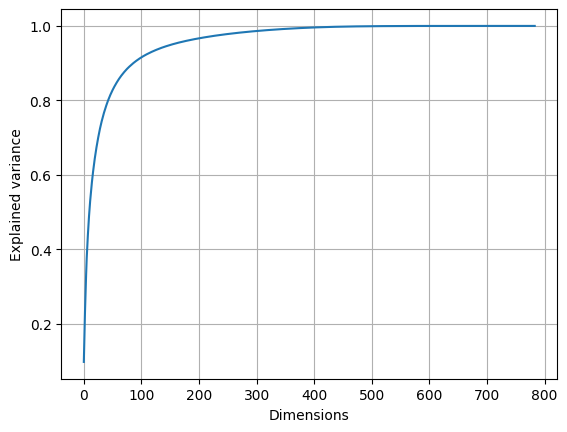

In [13]:
# plot the explained variance as a function of the number of dimensions
plt.plot(cumsum)
plt.grid()
plt.xlabel("Dimensions")
plt.ylabel("Explained variance")

In [14]:
# Tune number of dimensions like any other hyperparameter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [15]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [16]:
print(rnd_search.best_estimator_)

Pipeline(steps=[('pca', PCA(n_components=23, random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=465, random_state=42))])


In [17]:
# Get back to 784 dimensions
X_recovered = pca.inverse_transform(X_reduced)

In [22]:
print(X_reduced.shape)
print(pca.components_.shape)
print(X_recovered.shape)

(60000, 154)
(154, 784)
(60000, 784)


In [24]:
# Randomized PCA - drammatically faster approximation of the first d components
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [26]:
my_pca = PCA(n_components=154, svd_solver="full", random_state=42)
X_reduced = my_pca.fit_transform(X_train)

Full approach is actually faster than randomized. Randomized PCA should be faster though when n_components is much smaller than n_features

In [32]:
import time

n_components = 3
regular_pca = PCA(n_components=n_components, svd_solver="full", random_state=42)
rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

for name, pca in (("PCA", regular_pca), ("Rnd PCA", rnd_pca)):
    t1 = time.time()
    pca.fit(X_train)
    t2 = time.time()
    print("    {}: {:.1f} seconds".format(name, t2 - t1))

    PCA: 4.0 seconds
    Rnd PCA: 5.0 seconds


Still no! Something else is going on.. maybe M2 chip optimizations for large matrix multiplications?

In [25]:
# Setting n_components to a float and svd_solver to 'randomized' raises an error
# my_pca = PCA(n_components=0.95, svd_solver="randomized", random_state=42)
# X_reduced = my_pca.fit_transform(X_train)

ValueError: n_components=0.95 must be between 1 and min(n_samples, n_features)=784 with svd_solver='randomized'

In [27]:
# IncrementalPCA for large training sets that don't fit in memory
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)  # partial_fit(), not fit()

X_reduced = inc_pca.transform(X_train)

In [28]:
# Alterantively, use numpy's memmap to read a large array from a file.
# First, create the file
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # in reality, we would fetch X_train in batches and load it chunk by chunk
X_mmap.flush()

In [29]:
# Load the file from disk and use it likey a regular numpy array
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0]  # n_batches - use the whole array as a batch
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)   # Call .fit() since we can read the whole dataset from the file (but then why use IncrementalPCA?)

IncrementalPCA(batch_size=60000, n_components=154)

In [30]:
# Regular PCA works too, as expected

my_pca = PCA(n_components=154, random_state=42)
my_pca.fit(X_mmap)

PCA(n_components=154, random_state=42)

### Random Projection

In [34]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m = 5000
eps = 0.1 # distances should not change more than 10%
d = johnson_lindenstrauss_min_dim(m, eps=eps)
d

7300

In [35]:
# Random projection by hand
n = 20_000  # n_features
np.random.seed(42)
# multiplying by 1 / sqrt(d) results in variance (1/sqrt(d))^2 = 1/d
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)  # generate a fake dataset
X_reduced = X @ P.T  # like in Equation 8-2

In [36]:
# Using sklearn
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=eps, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [38]:
gaussian_rnd_proj.components_.shape  # like P we computed earlier

(7300, 20000)

In [39]:
# SparseRandomProjection should be much faster

from sklearn.random_projection import SparseRandomProjection

sparse_rnd_proj = SparseRandomProjection(eps=eps, random_state=42)
X_reduced = sparse_rnd_proj.fit_transform(X)

In [40]:
# Inverse transform
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

### Locally Linear Embedding

In [41]:
# Good for unrolling twisted manifolds...
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

Text(0.5, 1.0, 'Unrolled swiss roll using LLE')

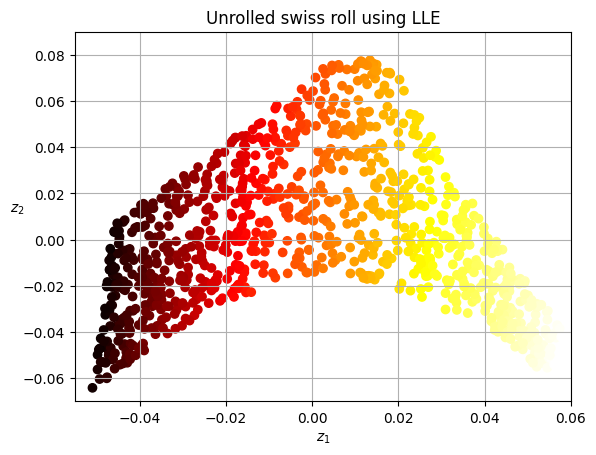

In [43]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap="hot")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")